In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skopt import gp_minimize
from skopt.space import Real, Integer
from skimage import color

In [2]:
def calculate_psnr(imageA, imageB):
    if imageA.shape != imageB.shape:
        raise ValueError("The images must have the same dimensions.")
    
    psnr_value = cv2.PSNR(imageA, imageB)
    return psnr_value

def calculate_ssim(image1, image2, win_size=3):
    if image1 is None or image2 is None:
        raise ValueError("Uma ou ambas as imagens não puderam ser carregadas.")
    
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    if image1.shape != image2.shape:
        raise ValueError("As imagens devem ter as mesmas dimensões.")
    ssim_value = ssim(image1, image2, multichannel=True, win_size=win_size)
    return ssim_value

def calculate_mscn_coefficients(image):
    c = np.fft.fft2(image)
    c_shifted = np.fft.fftshift(c)
    magnitude = np.abs(c_shifted)
    log_magnitude = np.log(1.0 + magnitude)
    c_shifted_real = np.real(c_shifted)
    c_shifted_imag = np.imag(c_shifted)
    return c_shifted_real, c_shifted_imag, magnitude, log_magnitude

def calculate_mscn_features(image):
    c_shifted_real, c_shifted_imag, _, log_magnitude = calculate_mscn_coefficients(image)
    std_dev = np.std(log_magnitude)
    mean = np.mean(log_magnitude)
    return [std_dev, mean]
def brisque_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ms_std_dev, ms_mean = calculate_mscn_features(gray)
    return [ms_std_dev, ms_mean]

def getBRISQUE(image):
    features = brisque_features(image)
    weights = [-0.0977446, 0.0270277, 0.00090095, 0.0793246, 0.0476165,-0.033992,-0.0535509, 0.276186, 0.189205, 0.255546,
    0.120626, 0.0471861,-0.18469, 0.154051,-0.173411,-0.413456]
    intercept = 18.9217
    score = intercept
    for i in range(len(features)):
        score += features[i] * weights[i]
    return score

def getNIQE(img):
 
    
    imagem_gray = color.rgb2gray(img)
    
    mean_local_contrast = np.mean(np.abs(np.gradient(imagem_gray)))
    
    std_local_contrast = np.std(np.abs(np.gradient(imagem_gray)))
    
    niqe_score = 1.0 / (1 + 6.6 * mean_local_contrast + 0.228 * std_local_contrast)
    return niqe_score


Processing image 1: ../Low-Light Image Quality Enhancement/images/low/5.png with reference ../Low-Light Image Quality Enhancement/images/high/5.png

Best parameters found:
Alpha=3.78, Beta=50.00, h=5.00, hForColor=5.00, TemplateWindow=3, SearchWindow=3

Quality Metrics (With Reference)
PSNR:  29.313697647474854
SSIM:  0.937631947278269
Quality Metrics (No Reference)
BRISQUE:  19.041619400428296
NIQE:  0.8676407916904768


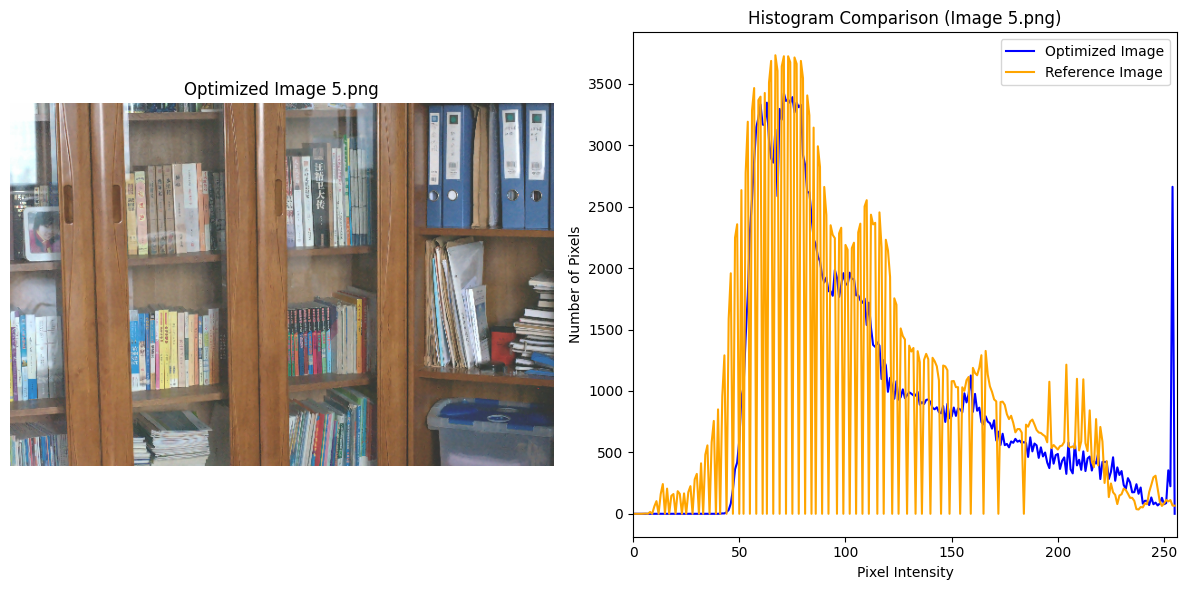


Processing image 2: ../Low-Light Image Quality Enhancement/images/low/62.png with reference ../Low-Light Image Quality Enhancement/images/high/62.png

Best parameters found:
Alpha=5.00, Beta=50.00, h=5.00, hForColor=20.00, TemplateWindow=3, SearchWindow=9

Quality Metrics (With Reference)
PSNR:  12.895684868996737
SSIM:  0.6512860308898656
Quality Metrics (No Reference)
BRISQUE:  19.04450331068506
NIQE:  0.9447975485090697


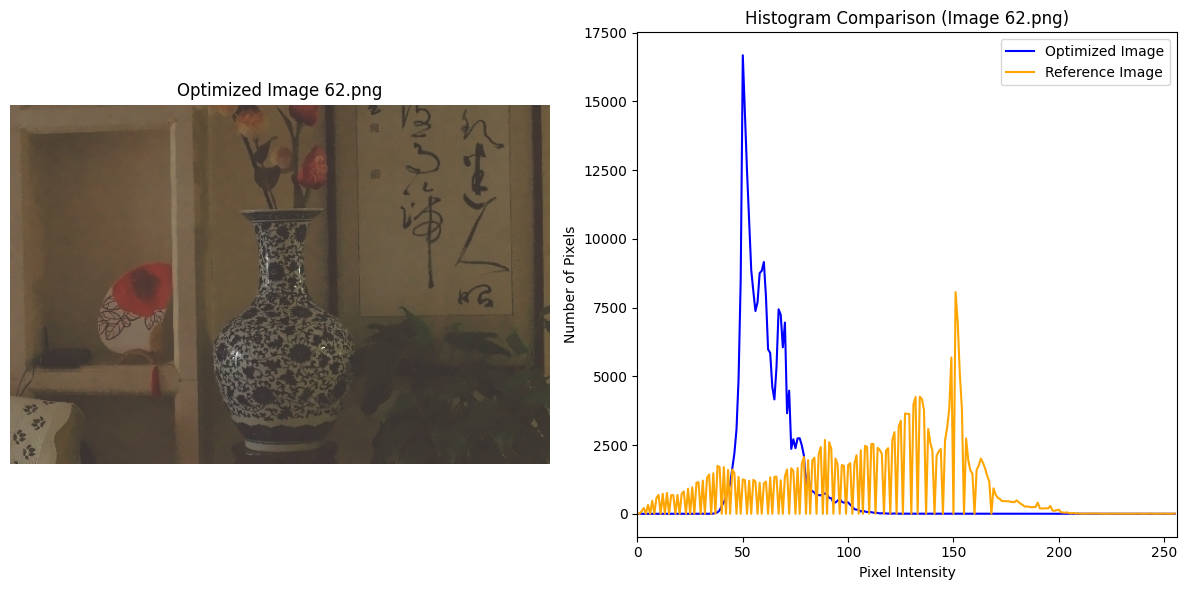


Processing image 3: ../Low-Light Image Quality Enhancement/images/low/233.png with reference ../Low-Light Image Quality Enhancement/images/high/233.png

Best parameters found:
Alpha=4.51, Beta=50.00, h=5.00, hForColor=5.00, TemplateWindow=6, SearchWindow=3

Quality Metrics (With Reference)
PSNR:  26.31915566810655
SSIM:  0.8943843653008862
Quality Metrics (No Reference)
BRISQUE:  19.056247717967207
NIQE:  0.8262487072914798


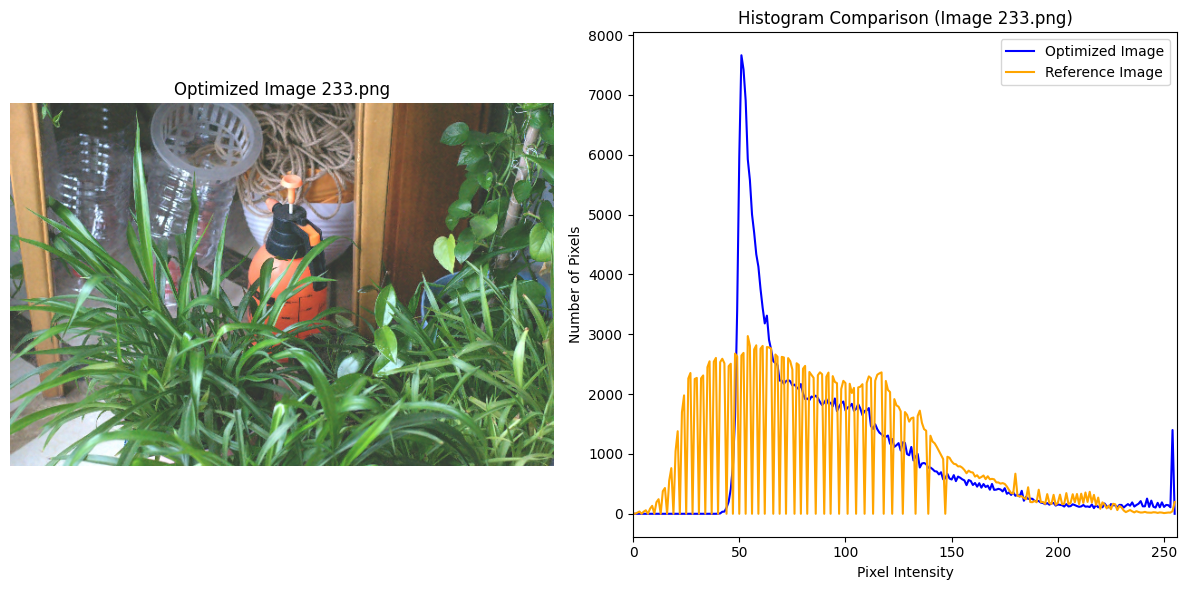


Processing image 4: ../Low-Light Image Quality Enhancement/images/low/772.png with reference ../Low-Light Image Quality Enhancement/images/high/772.png

Best parameters found:
Alpha=2.89, Beta=32.21, h=12.29, hForColor=5.00, TemplateWindow=3, SearchWindow=9

Quality Metrics (With Reference)
PSNR:  29.057653638994427
SSIM:  0.913633344044296
Quality Metrics (No Reference)
BRISQUE:  18.99943129562917
NIQE:  0.9213777644776424


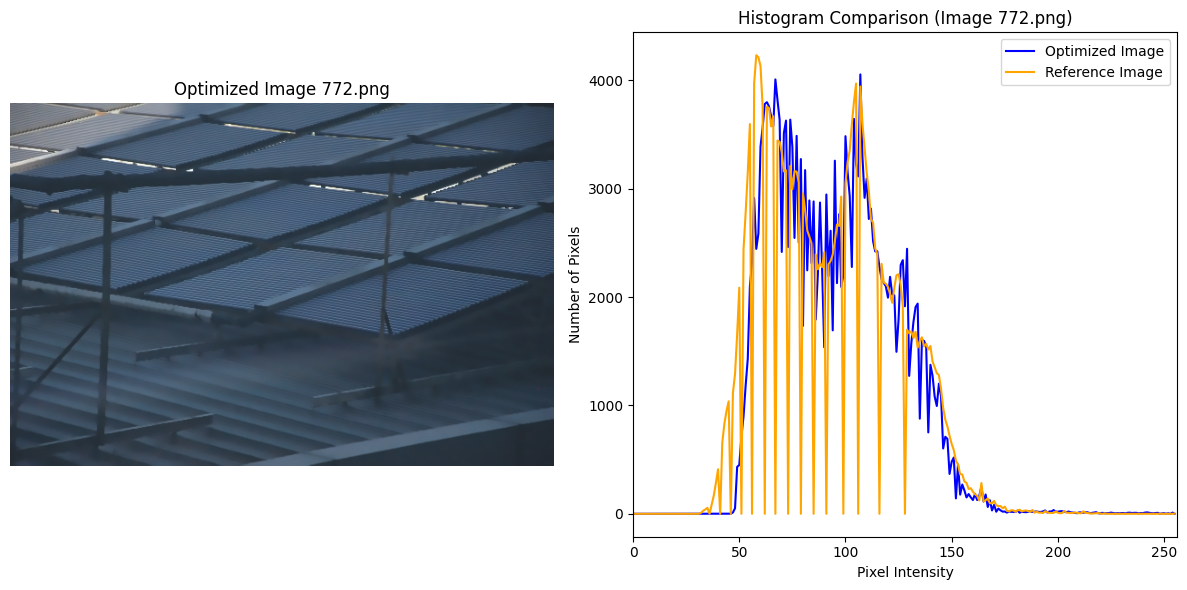


Processing image 5: ../Low-Light Image Quality Enhancement/images/low/770.png with reference ../Low-Light Image Quality Enhancement/images/high/770.png

Best parameters found:
Alpha=3.22, Beta=28.05, h=5.00, hForColor=5.00, TemplateWindow=3, SearchWindow=7

Quality Metrics (With Reference)
PSNR:  31.577009450766802
SSIM:  0.911382251930542
Quality Metrics (No Reference)
BRISQUE:  19.025575526168783
NIQE:  0.9376540118355615


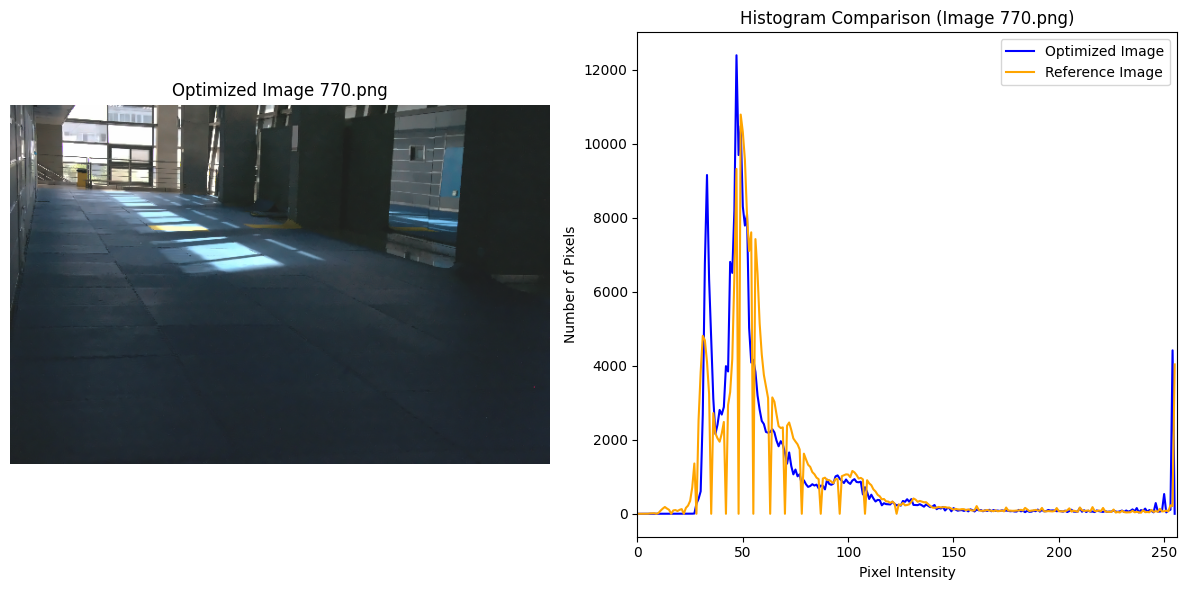


Processing image 6: ../Low-Light Image Quality Enhancement/images/low/141.png with reference ../Low-Light Image Quality Enhancement/images/high/141.png


c:\Users\Alex Viana\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 50.0, 5.0, 5.0, 9, 9] before, using random point [2.881411229059894, 44.846774546477086, 14.052744689069439, 12.14676883450186, 8, 6]
  warnings.warn(
c:\Users\Alex Viana\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 50.0, 30.0, 5.0, 9, 9] before, using random point [2.031286572085497, 19.20791101278675, 19.603637425729282, 7.82969845504077, 9, 7]
  warnings.warn(
c:\Users\Alex Viana\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5.0, 50.0, 30.0, 5.0, 9, 9] before, using random point [2.1989841597679955, 2.5891390743894913, 19.532937870572695, 6.355684847532498, 5, 6]
  warnings.warn(
c:\Users\Alex Viana\AppData


Best parameters found:
Alpha=5.00, Beta=50.00, h=30.00, hForColor=5.00, TemplateWindow=9, SearchWindow=9

Quality Metrics (With Reference)
PSNR:  20.451629698317383
SSIM:  0.6172721577624567
Quality Metrics (No Reference)
BRISQUE:  18.98209052222804
NIQE:  0.9929833644503036


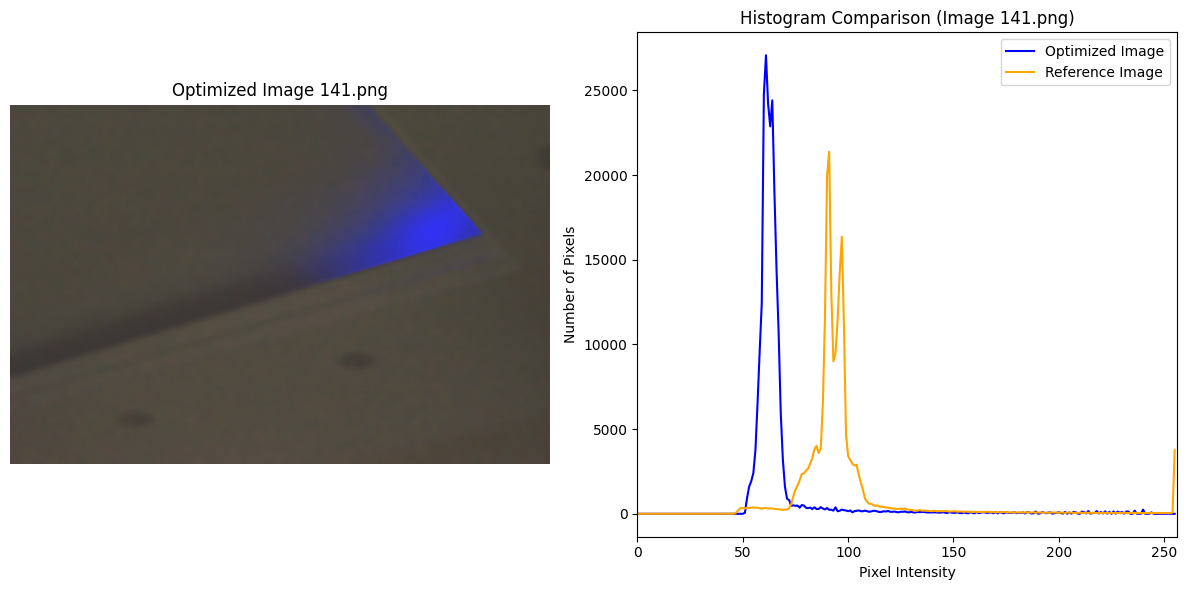

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import os  

# List of pairs of input and reference images
images = [
    ("../Low-Light Image Quality Enhancement/images/low/5.png", "../Low-Light Image Quality Enhancement/images/high/5.png"),
    ("../Low-Light Image Quality Enhancement/images/low/62.png", "../Low-Light Image Quality Enhancement/images/high/62.png"),
    ("../Low-Light Image Quality Enhancement/images/low/233.png", "../Low-Light Image Quality Enhancement/images/high/233.png"),
    ("../Low-Light Image Quality Enhancement/images/low/772.png", "../Low-Light Image Quality Enhancement/images/high/772.png"),
    ("../Low-Light Image Quality Enhancement/images/low/770.png", "../Low-Light Image Quality Enhancement/images/high/770.png"),
    ("../Low-Light Image Quality Enhancement/images/low/141.png", "../Low-Light Image Quality Enhancement/images/high/141.png")
]

def evaluate(params, image, reference_image):
    alpha, beta, h, hForColorComponents, templateWindowSize, searchWindowSize = params

    # Adjust brightness and contrast
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    # Apply the filter with the varied parameters
    final_result = cv2.fastNlMeansDenoisingColored(
        adjusted,
        None,  
        h,  
        hForColorComponents,  
        templateWindowSize, 
        searchWindowSize  
    )
    # Calculate quality metrics
    psnr = calculate_psnr(final_result, reference_image)
    ssim_value = calculate_ssim(final_result, reference_image)
    brisque = getBRISQUE(final_result)
    niqe = getNIQE(final_result)

    score = -psnr - ssim_value + brisque + niqe
    return score

# Defining the parameter space
space = [
    Real(1.0, 5.0, name='alpha'),  # Brightness
    Real(0.0, 50.0, name='beta'),  # Contrast
    Real(5.0, 30.0, name='h'),  # Degree of filtering for luminance
    Real(5.0, 20.0, name='hForColorComponents'),  # Degree of filtering for chrominance
    Integer(3, 9, name='templateWindowSize'),  # Template window size
    Integer(3, 9, name='searchWindowSize')  # Search window size
]

# Loop to process each pair of images
for i, (input_path, reference_path) in enumerate(images, start=1):
    print(f"\nProcessing image {i}: {input_path} with reference {reference_path}")

    # Load the images
    image = cv2.imread(input_path, 1)
    reference_image = cv2.imread(reference_path, 1)

    # Perform Bayesian optimization
    result = gp_minimize(lambda params: evaluate(params, image, reference_image), space, n_calls=50, random_state=0)

    # Display the best parameters found
    best_params = result.x
    best_psnr = -result.fun  
    best_alpha, best_beta, best_h, best_hForColorComponents, best_templateWindowSize, best_searchWindowSize = best_params

    print("\nBest parameters found:")
    print(f"Alpha={best_alpha:.2f}, Beta={best_beta:.2f}, h={best_h:.2f}, hForColor={best_hForColorComponents:.2f}, "
          f"TemplateWindow={best_templateWindowSize}, SearchWindow={best_searchWindowSize}\n")

    # Apply the best parameters
    optimized_image = cv2.convertScaleAbs(image, alpha=best_alpha, beta=best_beta)

    # Process the image with the best parameters
    final_result = cv2.fastNlMeansDenoisingColored(
        optimized_image,
        None,
        best_h,  # Degree of filtering for luminance
        best_hForColorComponents,  # Degree of filtering for chrominance
        best_templateWindowSize,  # Template window size
        best_searchWindowSize  # Search window size
    )

    
    original_name = os.path.basename(input_path)  
    output_path = f"../Low-Light Image Quality Enhancement/images/out/Enhanced_{original_name}"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)


    
    cv2.imwrite(output_path, final_result)

    # Calculate and display quality metrics
    psnr = calculate_psnr(final_result, reference_image)
    ssim_value = calculate_ssim(final_result, reference_image)
    brisque = getBRISQUE(final_result)
    niqe = getNIQE(final_result)

    print("Quality Metrics (With Reference)")
    print("PSNR: ", psnr)
    print("SSIM: ", ssim_value)
    print("Quality Metrics (No Reference)")
    print("BRISQUE: ", brisque)
    print("NIQE: ", niqe)

    # Histogram comparison
    hist_optimized = cv2.calcHist([final_result], [0], None, [256], [0, 256])
    hist_reference = cv2.calcHist([reference_image], [0], None, [256], [0, 256])

    # Display optimized image and histograms side by side
    plt.figure(figsize=(12, 6))

    # Subplot for the optimized image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title(f"Optimized Image {original_name}")
    plt.axis("off")

    # Subplot for the histogram
    plt.subplot(1, 2, 2)
    plt.title(f"Histogram Comparison (Image {original_name})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Number of Pixels")
    plt.plot(hist_optimized, label="Optimized Image", color='blue')
    plt.plot(hist_reference, label="Reference Image", color='orange')
    plt.xlim([0, 256])
    plt.legend()

    
    plt.tight_layout()
    plt.show()
